In [88]:
import nighres
import numpy
import math
import nibabel
from PIL import Image
from nighres.io import load_volume, save_volume
import scipy.ndimage
from scipy.signal import convolve2d
import os
from nibabel import processing
import subprocess
import shutil
import pandas as pd
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [96]:


# _df = pd.read_csv('/data/data_drive/Macaque_CB/processing/results_from_cell_counts/all_TP_image_idxs_file_lookup.csv')

# missing_idxs_to_fill = [4]
# # missing_idxs_to_fill = [3]
# # missing_idxs_to_fill = None
# all_image_fnames = list(_df['file_name'].values)

# pre_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix.nii.gz'

pre_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'
current_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0056_slide_43_Image_01_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

# post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix.nii.gz'
post_img = '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

In [ ]:
def do_reg(sources,targets,run_rigid=True,run_syn=False,file_name='XXX', output_dir ='./'):
    reg = nighres.registration.embedded_antspy_2d_multi(source_images=sources, 
                    target_images=targets,
                    run_rigid=run_rigid,
                    run_affine=False,
                    run_syn=run_syn,
                    scaling_factor=64,
                    cost_function='MutualInformation',
                    interpolation='Linear',
                    regularization='High',
                    convergence=1e-6,
                    mask_zero=False,
                    ignore_affine=False, ignore_orient=False, ignore_res=False,
                    save_data=True, overwrite=True,
                    file_name=file_name, output_dir=output_dir)
    return reg

def compute_intermediate_slice(pre_img,post_img,current_img=None,reg_refinement_iterations=10, idx=None):

    pre_post = do_reg([pre_img],[post_img],file_name='pre_post')
    post_pre = do_reg([post_img],[pre_img],file_name='post_pre')

    reg_pre = pre_post['transformed_source']
    reg_post = post_pre['transformed_source']

    #compute the average in each of the slice spaces, assume in same space!
    img = load_volume(reg_pre)
    avg_post = (img.get_fdata() + load_volume(post_img).get_fdata()) / 2
    # avg_post = nibabel.Nifti1Image(avg_post, img.affine, img.header, dtype=img.get_data_dtype())
    # avg_post_fname = './avg_post.nii.gz'
    # save_volume(avg_post_fname, avg_post,overwrite_file=True)

    img = load_volume(reg_post)
    avg_pre = (img.get_fdata() + load_volume(pre_img).get_fdata()) / 2

    avg = (avg_pre + avg_post)/2
    avg = nibabel.Nifti1Image(avg, img.affine, img.header, dtype=img.get_data_dtype())

    avg_fname = './avg.nii.gz'
    save_volume(avg_fname, avg ,overwrite_file=True)

    # avg_pre = nibabel.Nifti1Image(avg_pre, img.affine, img.header, dtype=img.get_data_dtype())
    # avg_pre_fname = './avg_pre.nii.gz'
    # save_volume(avg_pre_fname, avg_pre,overwrite_file=True)

    for refinement_iter in range(reg_refinement_iterations):
        #now register to the avg, conceptually in the middle of the two images
        pre_avg = do_reg([pre_img],[avg],file_name='pre_avg',run_syn=True)
        post_avg = do_reg([post_img],[avg],file_name='post_avg',run_syn=True)

        img1 = load_volume(pre_avg['transformed_source'])
        img2 = load_volume(post_avg['transformed_source'])

        avg = (img1.get_fdata() + img2.get_fdata()) / 2
        avg = nibabel.Nifti1Image(avg, img1.affine, img1.header, dtype=img1.get_data_dtype())
        save_volume(avg_fname, avg, overwrite_file=True)
    
    if current_img is not None:
        current_avg = load_volume(do_reg([current_img],[avg],file_name='current_avg',run_syn=True)['transformed_source'])
    else:
        current_avg = avg

    if idx is not None:
        return idx, current_avg.get_fdata()
    else:
        return current_avg.get_fdata()    
    
# avg = nibabel.Nifti1Image(avg, img.affine, img.header, dtype=img.get_data_dtype())


In [93]:
res_slice = compute_intermediate_slice(pre_img,post_img,current_img=current_img,reg_refinement_iterations=10)


Embedded ANTs Registration 2D Multi-contrasts

Outputs will be saved to ./

Saving ./pre_post_tmp_srccoordX.nii.gz

Saving ./pre_post_tmp_srccoordY.nii.gz

Saving ./pre_post_tmp_trgcoordX.nii.gz

Saving ./pre_post_tmp_trgcoordY.nii.gz
registering /data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0055__Image_42_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
 to /data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 2 --initialize-transforms-per-stage 0 --interpolation Linear --output pre_post_tmp_syn --transform Rigid[0.1] --metric MI[/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0057__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_co

FileNotFoundError: No such file or no access: '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0056__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

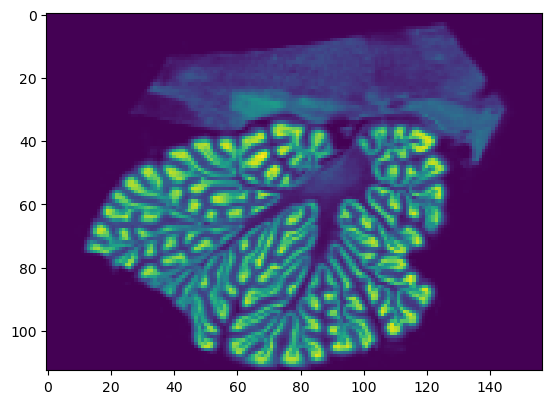

In [89]:

plt.imshow(res_slice)

In [95]:
do_reg([current_img],['./avg.nii.gz'],file_name='current_avg',run_syn=True)


Embedded ANTs Registration 2D Multi-contrasts

Outputs will be saved to ./


FileNotFoundError: No such file or no access: '/data/data_drive/Macaque_CB/processing/results_from_cell_counts/slice_reg_perSliceTemplate_image_weights/zefir_0056__Image_43_-_20x_cellCount_29_downsample_10p002um_pix_coreg0nl_ants-def0.nii.gz'

In [8]:
pre_post

{'transformed_sources': ['./pre_post_ants-def0.nii.gz'],
 'transformed_source': './pre_post_ants-def0.nii.gz',
 'mapping': './pre_post_ants-map.nii.gz',
 'inverse': './pre_post_ants-invmap.nii.gz'}

In [ ]:
def compute_intermediate_non_linear_slice(pre_img, post_img, current_img=None, additional_coreg_mean = True, 
                                          idx=None):
    